In [1]:
import os
import h5py
import numpy as np 
from sklearn.decomposition import NMF
from astropy.convolution import Gaussian1DKernel, convolve, Box1DKernel

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Read in TNG SFHs

In [3]:
f_sfh = os.path.join(os.environ['HOME'], 'data', 'gqp_mc', 'tng', 'IQ_TNG_SFRHs-corrected.hdf5')
fsfh = h5py.File(f_sfh, 'r')

sfhs = fsfh['SFRH'][...] # stellar mass formed in bins of time and metallicity

In [4]:
# we don't care much about metallicity bins so lets add them up.
# also the last min in SFH doesn't make sense
sfhs_t = np.sum(sfhs, axis=2)[:,:-1] # SFH(t)

In [5]:
# read in corresponding bin edges
_t_low, _t_high = np.loadtxt(os.path.join(os.environ['HOME'], 'data', 'gqp_mc', 'tng', 't_sfh.txt'), delimiter=',', unpack=True, usecols=[0,1])
t_low = _t_low[:-1]
t_high = _t_high[:-1]
t_mid = 0.5 * (t_low + t_high)
dt = t_high - t_low

Recent SFHs are binned way too finely. Lets rebin in cosmic time

In [6]:
t_low_coarse = np.concatenate([[0., 0.075, 0.175], t_low[14:]])
t_high_coarse = np.concatenate([t_low_coarse[1:], [t_high[-1]]])
t_mid_coarse = 0.5 * (t_low_coarse + t_high_coarse)
dt_coarse = t_high_coarse - t_low_coarse

In [7]:
sfhs_t_coarse = np.empty((sfhs_t.shape[0], len(dt_coarse)))
sfhs_t_coarse[:,3:] = sfhs_t[:,14:]
sfhs_t_coarse[:,0] = np.sum(sfhs_t[:,:8], axis=1)
sfhs_t_coarse[:,1] = np.sum(sfhs_t[:,8:12], axis=1)
sfhs_t_coarse[:,2] = np.sum(sfhs_t[:,12:14], axis=1)

In [8]:
print((np.sum(sfhs_t, axis=1) - np.sum(sfhs_t_coarse, axis=1)).max())

1.8189894035458565e-12


In [9]:
sfrhs_t = sfhs_t_coarse / dt_coarse # divide by bin width to get SFR
Msum = np.trapz(sfrhs_t, t_mid_coarse) # noramlization 

normed_sfrhs_t = sfrhs_t / Msum[:,None]

(0.0, 1.0)

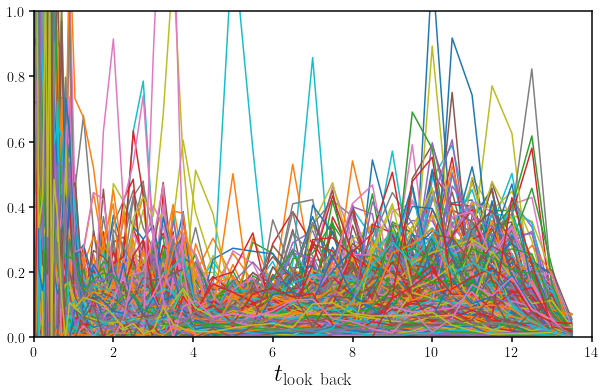

In [10]:
fig = plt.figure(figsize=(10, 6))
sub = fig.add_subplot(111)
for i in np.random.choice(np.arange(sfhs.shape[0]), size=1000): 
    sub.plot(t_mid_coarse, normed_sfrhs_t[i])
sub.set_xlabel(r'$t_{\rm look~back}$', fontsize=25)
sub.set_xlim(0., 14)
sub.set_ylim(0., 1)

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(0.0, 3.5415868259169248)

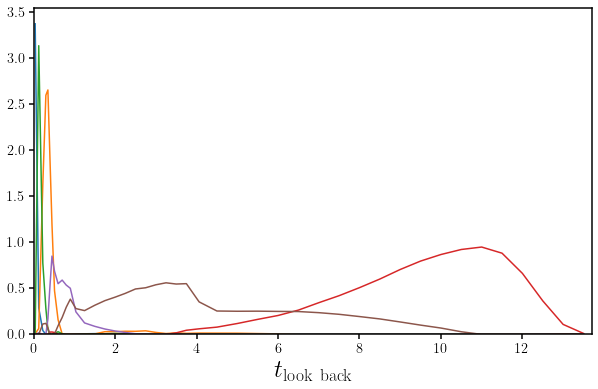

In [11]:
model = NMF(n_components=6, init='random', random_state=0)
W = model.fit_transform(normed_sfrhs_t[Msum > 1e1])
H = model.components_

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
for _H in H: 
    sub.plot(t_mid_coarse, _H)
sub.set_xlabel(r'$t_{\rm look~back}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylim(0, None)

Lets try smoothing it out a bit

In [12]:
def smooth_SFH(y, smooth_std):
    g = Box1DKernel(smooth_std, mode='center')
    y_smooth = convolve(y, g, boundary='extend')
    return y_smooth

In [13]:
smooth_normed_sfrhs_t = np.array([smooth_SFH(normed_sfrhs_t[i,:], 10) for i in range(normed_sfrhs_t.shape[0])])

(0.0, 1.0)

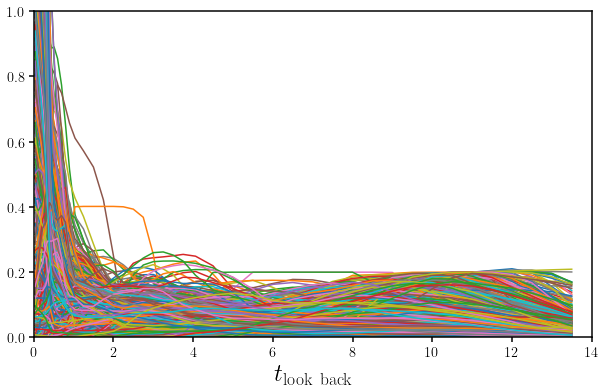

In [14]:
fig = plt.figure(figsize=(10, 6))
sub = fig.add_subplot(111)
for i in np.random.choice(np.arange(sfhs.shape[0]), size=1000): 
    sub.plot(t_mid_coarse, smooth_normed_sfrhs_t[i])
sub.set_xlabel(r'$t_{\rm look~back}$', fontsize=25)
sub.set_xlim(0., 14)
sub.set_ylim(0., 1)

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(0.0, 2.221737240650432)

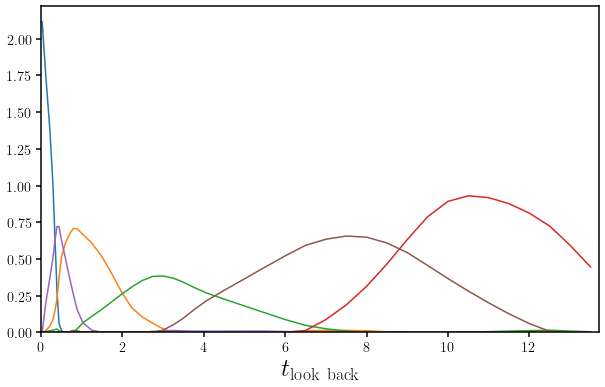

In [15]:
model = NMF(n_components=6, init='random', random_state=0)
W = model.fit_transform(smooth_normed_sfrhs_t[Msum > 1e1])
H = model.components_

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
for _H in H: 
    sub.plot(t_mid_coarse, _H)
sub.set_xlabel(r'$t_{\rm look~back}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylim(0, None)

Lets save the components

In [16]:
np.savetxt('t_sfh.tng.txt', t_mid_coarse)

In [17]:
np.savetxt('NMF_basis.sfh.6components.tng.txt', H.T)